# About SpaceNet

[SpaceNet](https://spacenetchallenge.github.io/) is a corpus of commercial satellite imagery and labeled training data to use for machine learning research. The dataset is currently hosted as an [Amazon Web Services (AWS) Public Dataset](https://aws.amazon.com/public-datasets/spacenet/).

The current SpaceNet corpus includes thousands of square kilometers of high resolution imagery collected from DigitalGlobe’s commercial satellites which includes 8-band multispectral data. This dataset is being made public to advance the development of algorithms to automatically extract geometric features such as roads, building footprints, and points of interest using satellite imagery. 

The currently available Areas of Interest (AOI) are:
- Rio de Janeiro
- Paris
- Las Vegas
- Shanghai
- Khartoum. 

The satellite imagery, along with training data, is provided via a collaboration between DigitalGlobe, CosmiQ Works, and NVIDIA.

# Rio de Janeiro labelled satellite imagery from SpaceNet

See https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html

In [1]:
from IPython.display import HTML
url = 'https://spacenetchallenge.github.io/AOI_Lists/AOI_1_Rio.html'
iframe = '<iframe src=' + url + ' width=100% height=600></iframe>'
HTML(iframe)

C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\IPython\core\display.py:701: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


# Set up Amazon Web Services Command Line Interface

In order to download the dataset, you'll need to install and configure the AWS command line interface.

See here: https://aws.amazon.com/cli/

First, pip install the aws command line interface:

In [2]:
#!pip install awscli

Next, configure the cli with you access key and secret access key from AWS console.

Something like this:

    !aws configure
    AWS Access Key ID [None]: "YOUR ACCESS KEY"
    AWS Secret Access Key [None]: "YOUR SECRET ACCESS KEY"
    Default region name [None]: us-west-2
    Default output format [None]: json

# View the contents of the dataset

In [3]:
!aws s3 ls spacenet-dataset/AOI_1_Rio/ --request-payer requester

                           PRE processedData/
                           PRE srcData/
                           PRE vectorData/


# Download the data

Download 200m x 200m tiles of AOI (3.4 GB) and building footprints

In [ ]:
%%time
!aws s3api get-object --bucket spacenet-dataset --key AOI_1_Rio/processedData/processedBuildingLabels.tar.gz --request-payer requester processedBuildingLabels.tar.gz

# Unzip the data

Unzip the main folder

In [ ]:
!tar -xvzf processedBuildingLabels.tar.gz

Unzip the 3band satellite images

In [ ]:
!tar -xvzf processedBuildingLabels/3band.tar.gz

Unzip the geojson containing labels

In [ ]:
!tar -xvzf processedBuildingLabels/vectordata/geojson.tar.gz

# How many images are there?

In [5]:
import os
from os.path import join

In [6]:
images_folder = R"C:\Users\vivek_sh99\Desktop\DATASET\processedBuildingLabels\3band"
labels_folder = R"C:\Users\vivek_sh99\Desktop\DATASET\processedBuildingLabels\vectordata\geojson"

In [7]:
print(len([name for name in os.listdir(images_folder)]), "satellite images")

6940 satellite images


In [8]:
print(len([name for name in os.listdir(labels_folder)]), "geojson labels")

6940 geojson labels


# Read a few of the images into arrays

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

Try reading the first image.

In [10]:
img=np.array(Image.open(join(images_folder, os.listdir(images_folder)[0])))

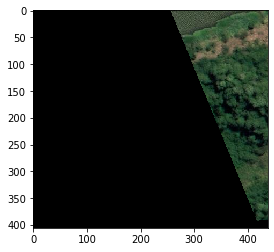

In [11]:
plt.imshow(img);

Here is the last image.

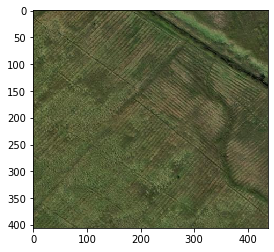

In [12]:
plt.imshow(np.array(Image.open(join(images_folder, os.listdir(images_folder)[-1]))));

# Read all the images into list of arrays

Converting to grayscale as they are opened.

In [13]:
images = [np.array(Image.open(join(images_folder, i)).convert('L')) for i in os.listdir(images_folder)]

In [14]:
print(len(images), "images")

6940 images


In [61]:
images[0].shape

(406, 438)

# Resize some of the images so that they are all the same size

Some images have shape of (406, 438), others have shape of (406, 439).

Change the (406, 439)'s to (406, 438).

In [15]:
for i in range(len(images)):
    if images[i].shape[1] == 439:
        images[i] = np.delete(images[i], 439-1, axis=1)

Change the (407, 438)'s to (406, 438)'s.

In [16]:
for i in range(len(images)):
    if images[i].shape[0] == 407:
        images[i] = np.delete(images[i], 407-1, axis=0)

# Downsample the images so they are smaller.

In [17]:
from skimage.transform import downscale_local_mean

4x downsampling.

In [18]:
downscaled_images = []
for i in range(len(images)):
    downscaled_images.append(downscale_local_mean(images[i], (4,4)))

In [19]:
downscaled_images[0].shape

(102, 110)

Original image:

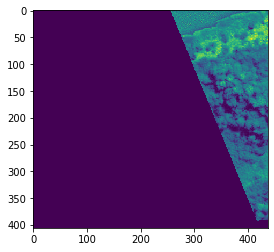

In [20]:
plt.imshow(images[0]);

Downscaled image:

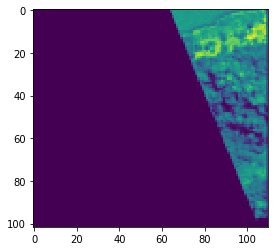

In [21]:
plt.imshow(downscaled_images[0]);

# Convert this list of downscaled arrays into a 3D array

In [22]:
shape = list(downscaled_images[0].shape)
shape[:0] = [len(downscaled_images)]
array_of_images = np.concatenate(downscaled_images).reshape(shape)

In [23]:
array_of_images.shape

(6940, 102, 110)

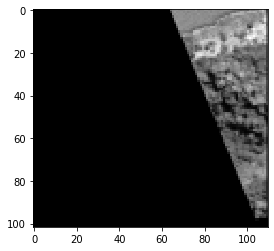

In [24]:
plt.imshow(array_of_images[0], cmap="gray");

# Parse the geojson labels for 1 = building, 0 = no building

In [25]:
import json

Read in all the geojsons.

In [26]:
labels = [json.load(open(join(labels_folder, i))) for i in os.listdir(labels_folder)]

# Create an array containing 1 = buildings, 0 = no buildings

In [27]:
def parse_labels(labels):
    
    results = []
    
    for label in labels:
        
        features = label['features']
        
        # If no features at all, append 0
        if len(features) == 0:
            results.append(0)
            
        # Otherwise, look for building property
        else:
            buildings_in_this_label = []
            for feature in features:
                properties = feature['properties']
                if 'building' in properties.keys():
                    if properties['building'] == 'yes':
                        buildings_in_this_label.append(1)
                    else:
                        buildings_in_this_label.append(0)
                else:
                    buildings_in_this_label.append(0)
            
            # If there is at least one building in this label, append 1
            if sum(buildings_in_this_label) > 0:
                results.append(1)
                
            # Otherwise append 0
            else:
                results.append(0)
                        
    array = np.array(results)
    return array

In [28]:
buildings_no_buildings = parse_labels(labels)

In [29]:
print(buildings_no_buildings.sum(), "of the", buildings_no_buildings.shape[0], "images contain buildings")

4302 of the 6940 images contain buildings


# Frame this as a machine learning problem

In [30]:
X = array_of_images
y = buildings_no_buildings

In [31]:
X.shape

(6940, 102, 110)

In [32]:
y.shape

(6940,)

# Split data into training and testing data

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [35]:
X_train.shape

(5205, 102, 110)

In [36]:
y_train.shape

(5205,)

In [37]:
X_test.shape

(1735, 102, 110)

In [38]:
y_test.shape

(1735,)

# Convolutional Neural Network

In [39]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('th')

Using TensorFlow backend.
C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\vivek_sh99\Anaconda3\envs\

In [40]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# reshape to be [samples][bands][width][height]
X_train = X_train.reshape(X_train.shape[0], 1, X_train[0].shape[0], X_train[0].shape[1]).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 1, X_test[0].shape[0], X_test[0].shape[1]).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# convert label arrays to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [41]:
# define the model
def cnn():
    model = Sequential()
    
    model.add(Conv2D(50, (5, 5), input_shape=(1, X_train.shape[2], X_train.shape[3]), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(15, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [44]:
%%time
# build the model
model = cnn()
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100, verbose=2)
# Final evaluation of the model
scores,acc = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 5205 samples, validate on 1735 samples
Epoch 1/20
 - 154s - loss: 0.4751 - acc: 0.7424 - val_loss: 0.4708 - val_acc: 0.8133
Epoch 2/20
 - 151s - loss: 0.3090 - acc: 0.8690 - val_loss: 0.2711 - val_acc: 0.8847
Epoch 3/20
 - 135s - loss: 0.2783 - acc: 0.8747 - val_loss: 0.2895 - val_acc: 0.8755
Epoch 4/20
 - 116s - loss: 0.2589 - acc: 0.8922 - val_loss: 0.2522 - val_acc: 0.8888
Epoch 5/20
 - 114s - loss: 0.2608 - acc: 0.8907 - val_loss: 0.2702 - val_acc: 0.8876
Epoch 6/20
 - 113s - loss: 0.2439 - acc: 0.9012 - val_loss: 0.2517 - val_acc: 0.8916
Epoch 7/20
 - 114s - loss: 0.2393 - acc: 0.9001 - val_loss: 0.2399 - val_acc: 0.8974
Epoch 8/20
 - 113s - loss: 0.2427 - acc: 0.8974 - val_loss: 0.2444 - val_acc: 0.8945
Epoch 9/20
 - 114s - loss: 0.2339 - acc: 0.9049 - val_loss: 0.2499 - val_acc: 0.8951
Epoch 10/20
 - 120s - loss: 0.2219 - acc: 0.9055 - val_loss: 0.2608 - val_acc: 0.8807
Epoch 11/20
 - 113s - loss: 0.2210 - acc: 0.9084 - val_loss: 0.2381 - val_acc: 0.9003
Epoch 12/20
 - 

IndexError: invalid index to scalar variable.

In [45]:
print('Test score:', scores)
print('Test accuracy:', acc)

Test score: 0.2668696632173975
Test accuracy: 0.8922190201729107


In [46]:
# save model
model_name = "building_no_building_new"

model.save(join(r"C:\Users\vivek_sh99\Desktop\DATASET\building-detection-master", model_name + ".h5"))

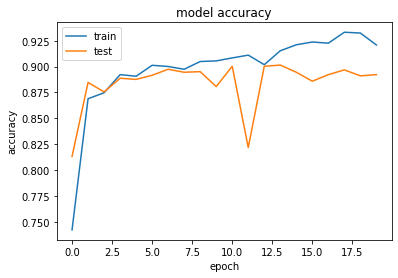

In [47]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

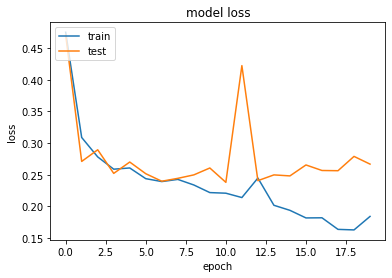

In [48]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [49]:
y_pred = model.predict_classes(X_test, batch_size=10)

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [51]:
y_test

array([1, 0, 0, ..., 1, 1, 0])

In [52]:
y_pred

array([1, 0, 1, ..., 1, 1, 0], dtype=int64)

Confusion matrix.

In [53]:
from sklearn.metrics import confusion_matrix
result=confusion_matrix(y_test, y_pred)
print(result)

[[576  91]
 [ 96 972]]


# View the first 50 predictions

In [54]:
def view_prediction_vs_actual(i, y_pred, X=X, y=y):
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.25, random_state=42)
    
    f, ax = plt.subplots()
    plt.imshow(X_test_orig[i], cmap='gray')
    
    prediction = ['no_building', 'building'][y_pred[i]]
    actual = ['no_building', 'building'][y_test_orig[i]]
    
    if prediction == actual:
        ax.annotate("CORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'green', 'alpha':0.9, 'pad':5})
    else:
        ax.annotate("INCORRECT", (5,90), color='white', weight='bold',fontsize=16, bbox={'facecolor':'red', 'alpha':0.9, 'pad':5})
    
    ax.annotate("prediction:  " + prediction, (5, 10), color='white', weight='bold',fontsize=16)
    ax.annotate("actual:  " + actual, (5, 20), color='white', weight='bold',fontsize=16)
    
    return f

C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


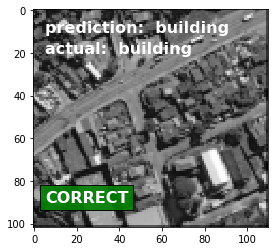

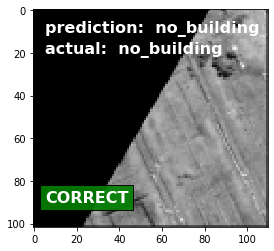

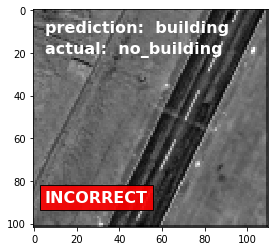

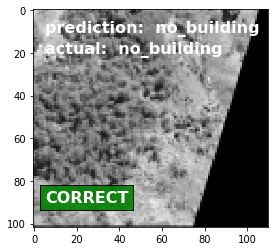

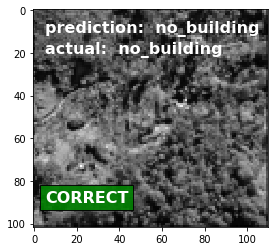

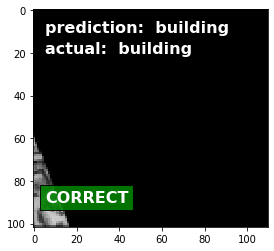

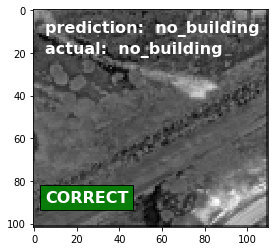

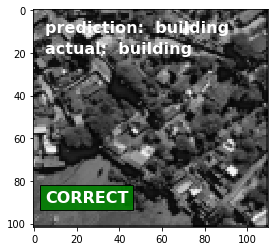

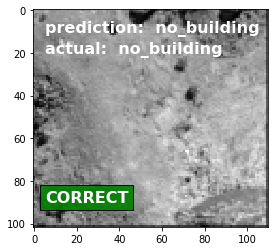

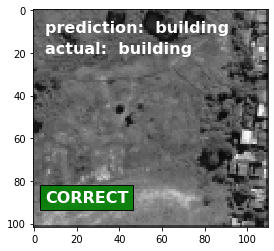

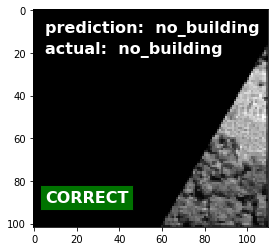

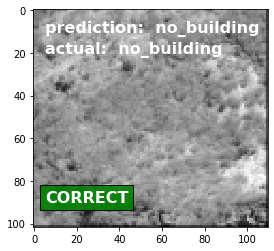

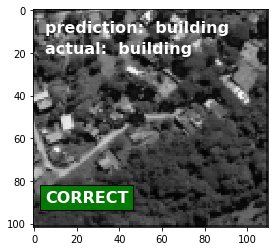

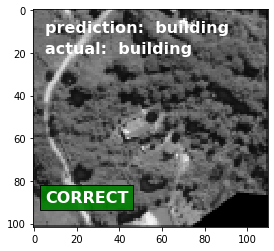

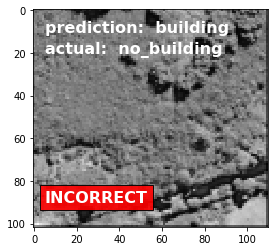

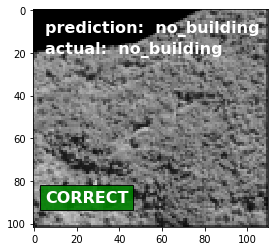

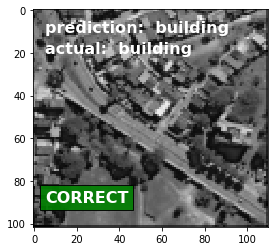

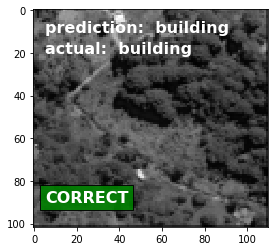

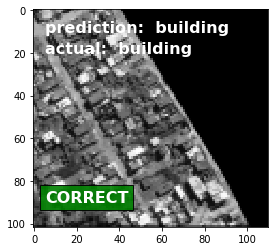

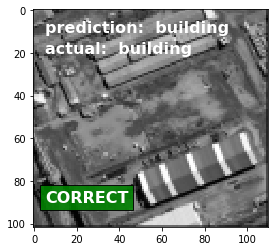

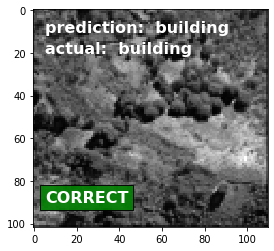

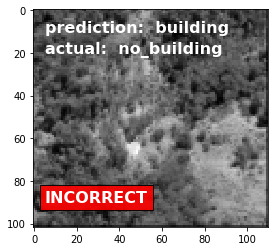

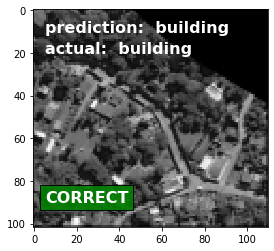

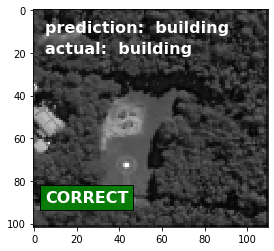

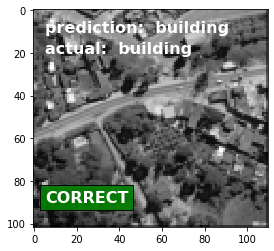

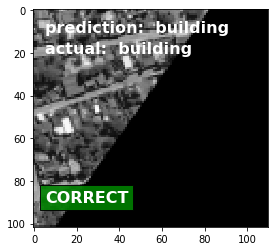

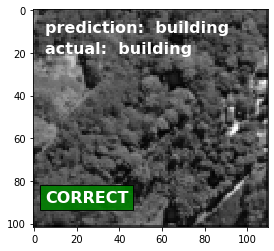

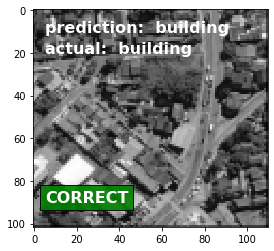

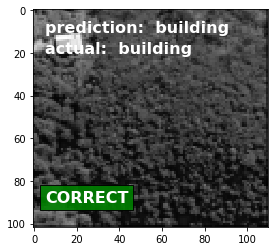

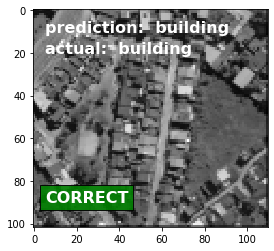

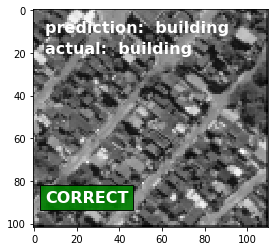

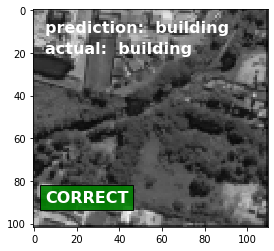

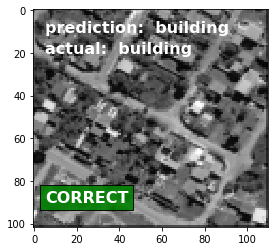

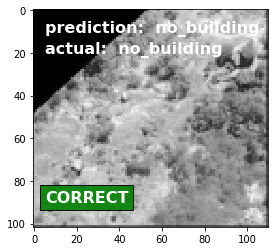

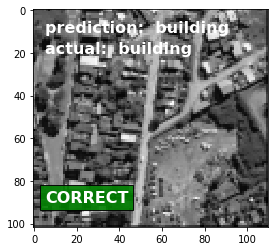

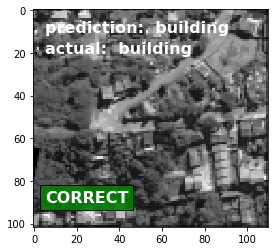

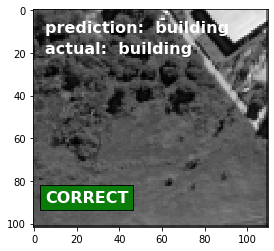

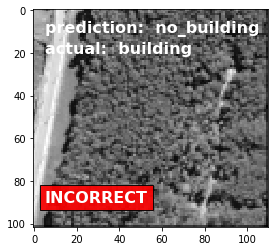

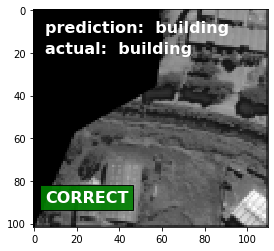

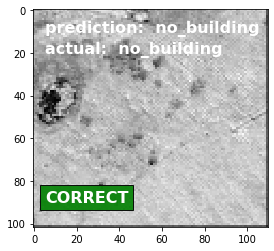

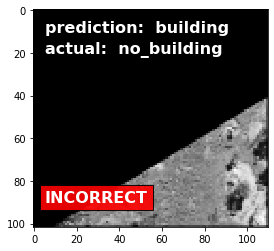

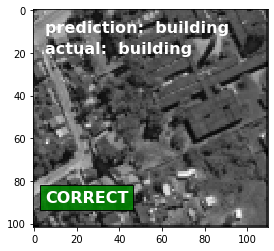

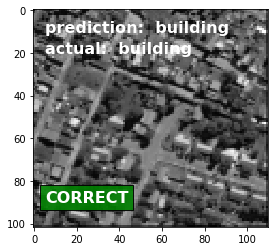

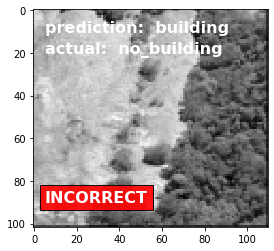

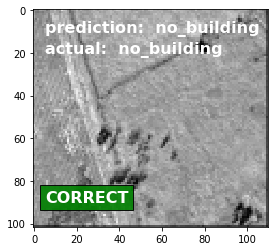

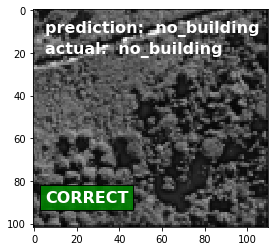

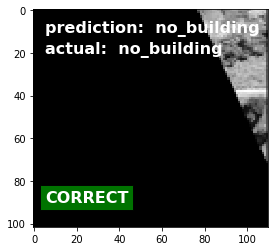

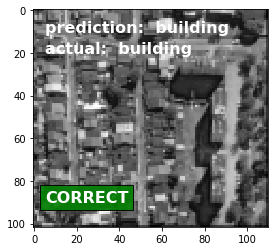

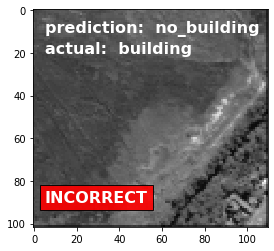

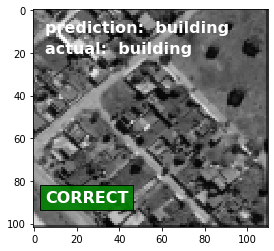

In [55]:
for i in range(50):
    
    view_prediction_vs_actual(i, y_pred)

# View the another 50 predictions

C:\Users\vivek_sh99\Anaconda3\envs\obj2\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


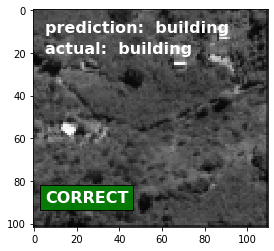

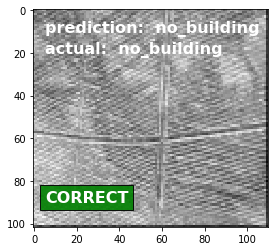

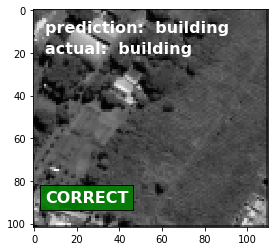

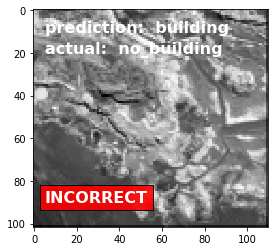

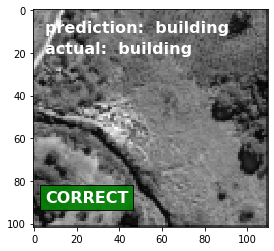

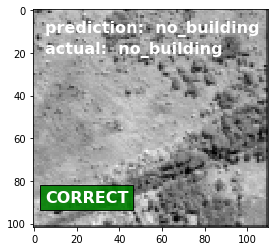

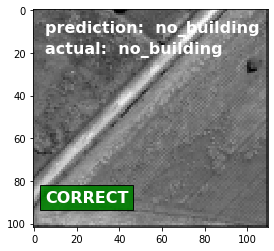

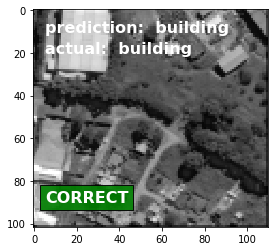

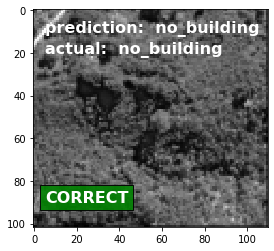

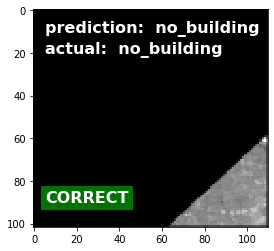

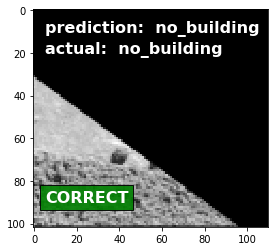

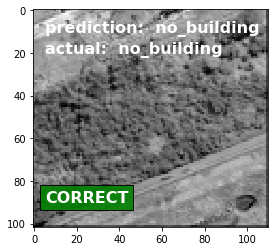

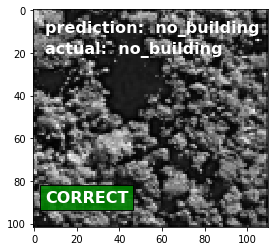

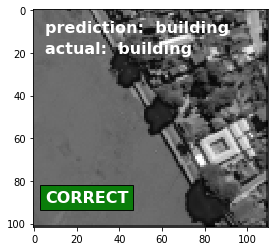

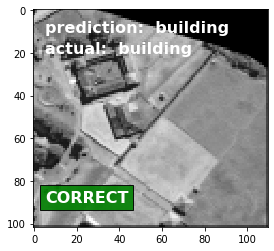

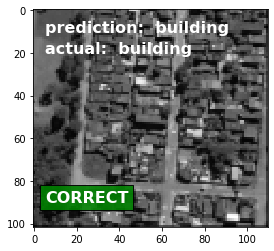

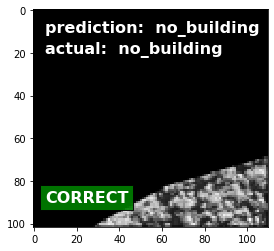

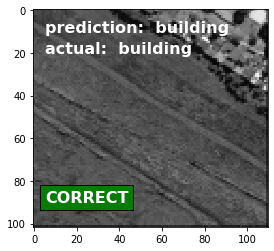

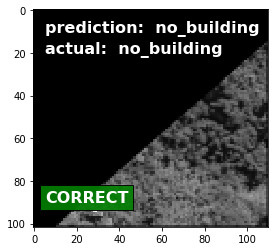

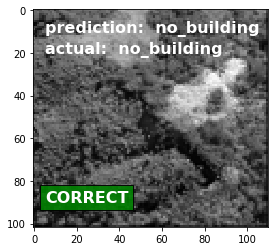

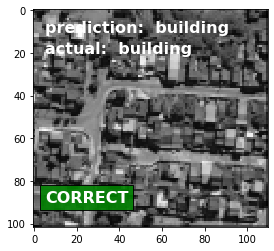

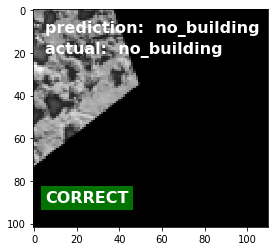

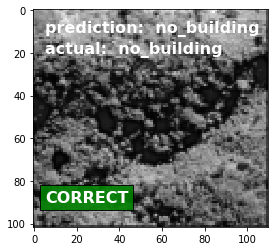

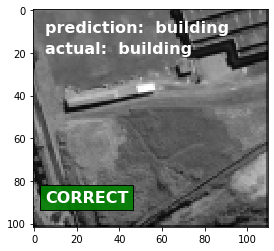

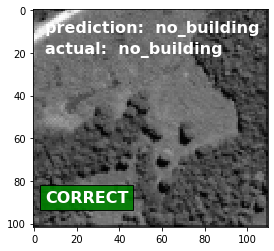

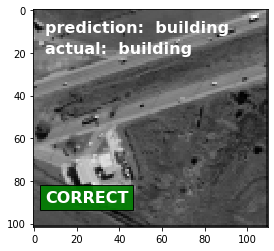

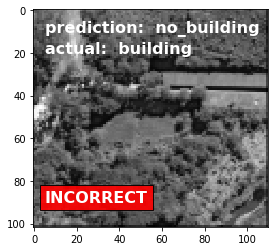

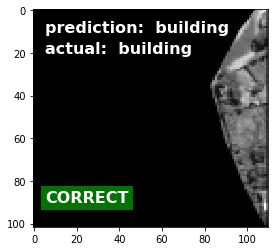

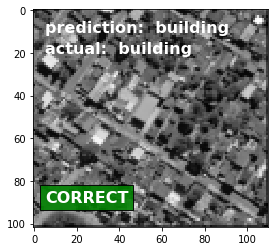

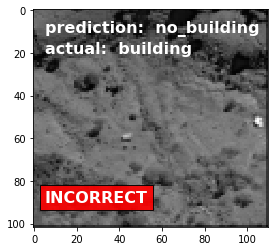

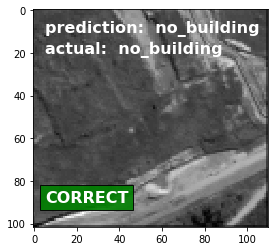

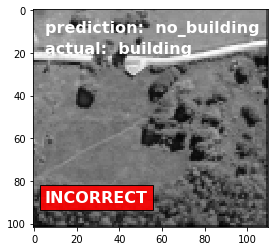

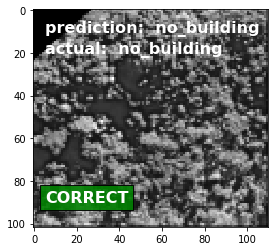

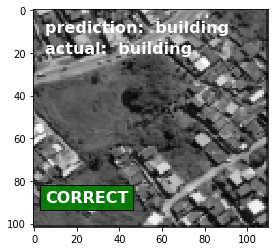

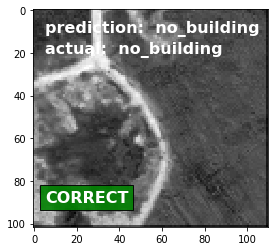

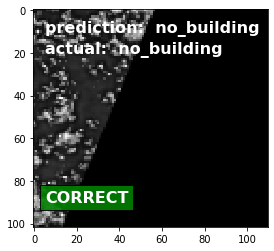

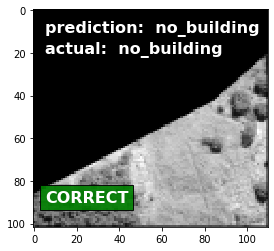

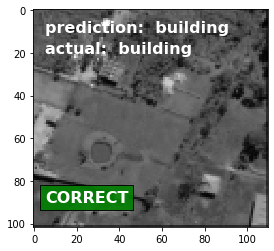

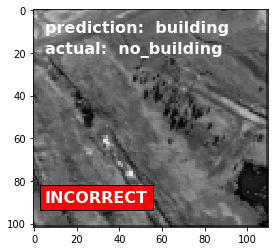

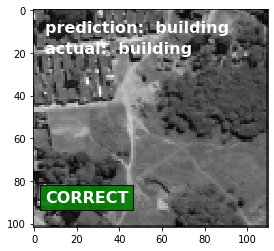

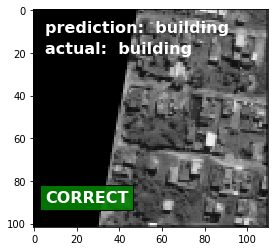

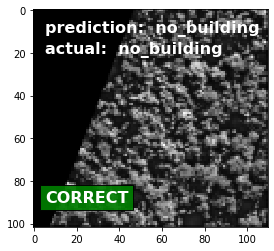

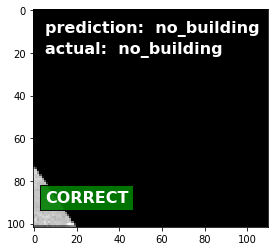

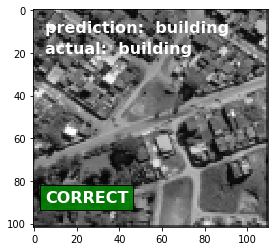

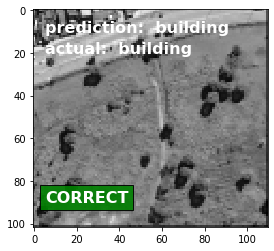

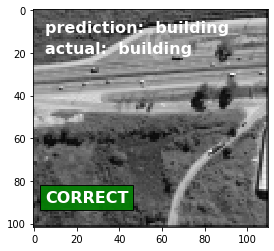

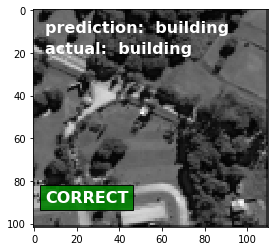

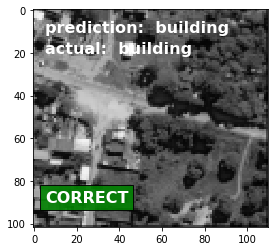

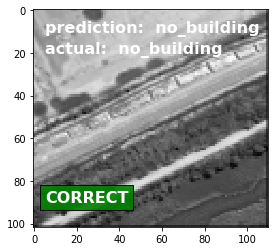

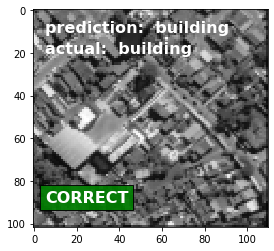

In [57]:
for i in range(50,100):
    
    view_prediction_vs_actual(i, y_pred)

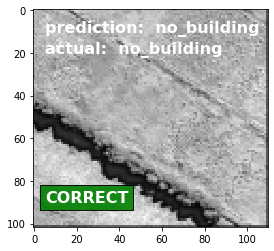

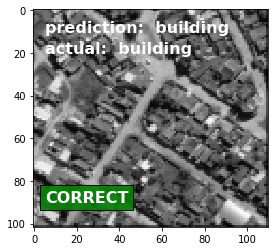

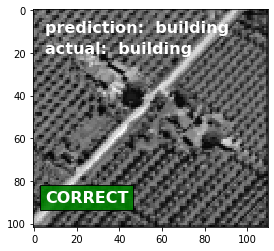

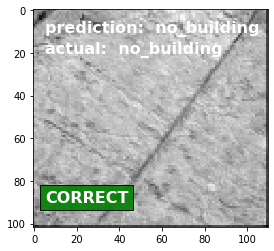

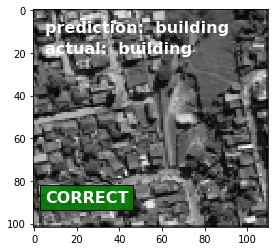

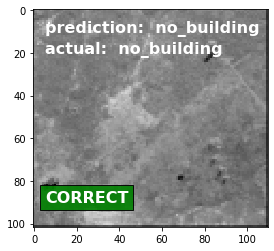

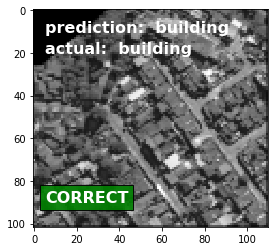

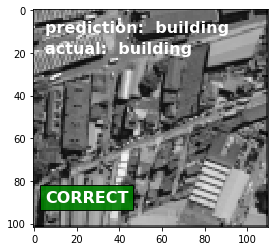

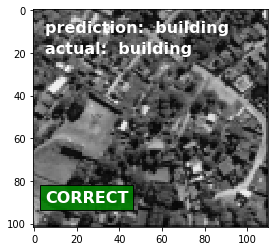

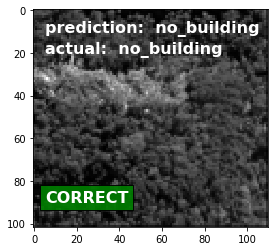

In [58]:
for i in range(500,600,10):
    
    view_prediction_vs_actual(i, y_pred)